In [1]:
import pymaid
import matplotlib.pyplot as plt

rm = pymaid.CatmaidInstance('server_url', 'api_token', 'http_user', 'http_password')

nl = pymaid.get_neurons('annotation:glomerulus DA1 right excitatory')

# Access single attribute: e.g. cable lengths [um]
nl.cable_length

INFO  : Global CATMAID instance set. (pymaid.fetch)
INFO  : Looking for Annotation(s): glomerulus DA1 right excitatory (pymaid.fetch)
INFO  : Found 8 skeletons with matching annotation(s) (pymaid.fetch)


array([1591.51982146, 1182.10245803, 1035.09925403, 1113.15667872,
       1215.92059396, 1182.6479815 , 1059.72905251, 1109.88615456])

In [2]:
# .. or get a full summary as pandas DataFrame
df = nl.summary()
df.head()

neuron_name skeleton_id  n_nodes  n_connectors  \
0      PN glomerulus DA1 27296 BH       27295     9969           463   
1      PN glomerulus DA1 57312 LK       57311     4874           421   
2  PN glomerulus DA1 57324 LK JSL       57323     4585           434   
3      PN glomerulus DA1 57354 GA       57353     4895           324   
4      PN glomerulus DA1 57382 ML       57381     7727           357   

   n_branch_nodes  n_end_nodes  open_ends  cable_length review_status  soma  
0             211          218         58   1590.676589            NA  True  
1             156          163        105   1180.597489            NA  True  
2             120          127         59   1035.076857            NA  True  
3              90           95         52   1113.156676            NA  True  
4             153          162         71   1215.920594            NA  True

In [3]:
# Reroot a single neuron to its soma
nl[0].soma

3005291

In [4]:
# .soma returns the treenode ID of the soma (if existing) and can be used to reroot
nl[0].reroot(nl[0].soma, inplace=True)

In [5]:
# You can also perform this operation on the entire CatmaidNeuronList
nl.reroot(nl.soma, inplace=True)

In [6]:
import navis
navis.reroot_neuron(nl, nl.soma, inplace=True)

In [7]:
# Downsample by "skipping" N nodes (here: 10) 
nl_downsampled = navis.downsample(nl, 10, inplace=False)
# More elaborate: resample to given resolution in nanometers (here: 1000nm = 1um)
nl_resampled = navis.resample_neuron(nl, 1000, inplace=False)

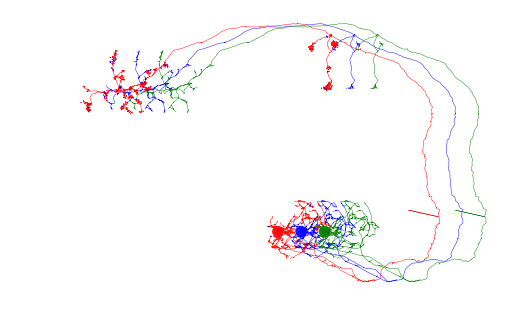

In [8]:
import matplotlib.pyplot as plt

# Plot an original neuron first
fig, ax = navis.plot2d(nl[0], color='red')

# Shift the downsampled and resampled versions slightly and plot
n_ds = nl_downsampled[0].copy()
n_rs = nl_resampled[0].copy()

n_ds.nodes.x += 10000
n_rs.nodes.x += 20000

fig, ax = n_ds.plot2d(color='blue', ax=ax)
fig, ax = n_rs.plot2d(color='green', ax=ax)

plt.show()

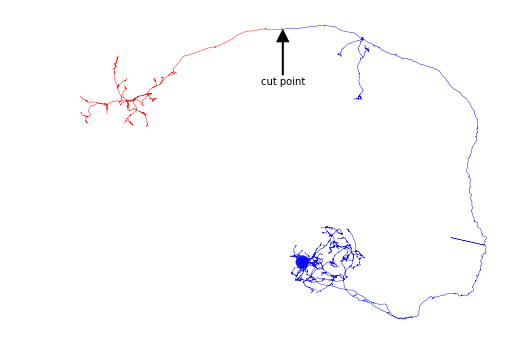

In [9]:
# Cut a neuron in two using either a node ID or (in this case) a node tag
distal, proximal = navis.cut_neuron(nl[0], cut_node='SCHLEGEL_LH')

# Plot neuron fragments
fig, ax = navis.plot2d(distal, color='red', method='2d', connectors=False)
fig, ax = navis.plot2d(proximal, color='blue', method='2d', connectors=False, ax=ax)

# Annotate cut point
cut_coords = distal.nodes.set_index('node_id').loc[ distal.root, ['x','y'] ].values[0]
ax.annotate('cut point', xy=(cut_coords[0], -cut_coords[1]), 
            xytext=(cut_coords[0], -cut_coords[1]-20000), va='center', ha='center',
            arrowprops=dict(facecolor='black', shrink=0.01, width=1),
            )

plt.show()

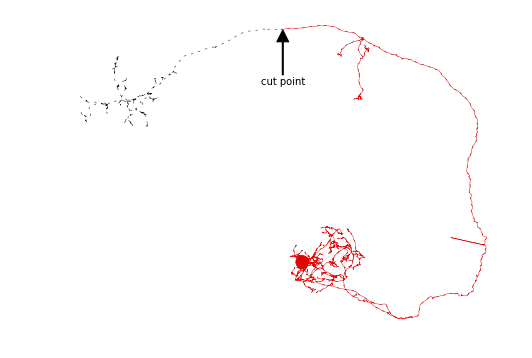

In [10]:
n = nl[0].prune_distal_to('SCHLEGEL_LH', inplace=False)

# Plot original neuron in black
fig, ax = nl[0].plot2d(color='black', method='2d', connectors=False, linestyle=(0, (5, 10)))

# Plot pruned neuron in red
fig, ax = n.plot2d(color='red', method='2d', connectors=False, ax=ax)

# Annotate cut point
ax.annotate('cut point', xy=(cut_coords[0], -cut_coords[1]), 
            xytext=(cut_coords[0], -cut_coords[1]-20000), va='center', ha='center',
            arrowprops=dict(facecolor='black', shrink=0.01, width=1),
            )

plt.show()

In [11]:
# To undo, simply reload the neuron from server
nl[0].reload()

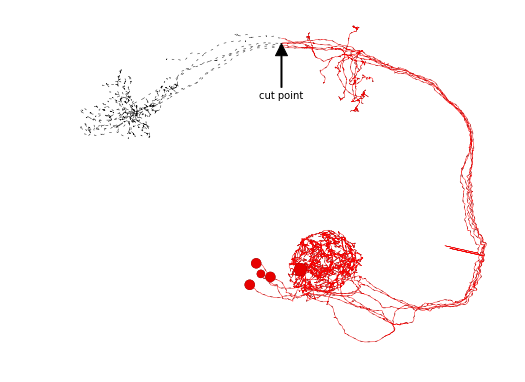

In [12]:
# These operations can also be performed on a collection of neurons
n = nl[:5].prune_distal_to('SCHLEGEL_LH', inplace=False)

# Plot original neurons in black
fig, ax = nl[:5].plot2d(color='black', method='2d', connectors=False, linestyle=(0, (5, 10)))

# Plot pruned neurons in red
fig, ax = n.plot2d(color='red', method='2d', connectors=False, ax=ax)

# Annotate cut point
ax.annotate('cut point', xy=(cut_coords[0], -cut_coords[1]), 
            xytext=(cut_coords[0], -cut_coords[1]-20000), va='center', ha='center',
            arrowprops=dict(facecolor='black', shrink=0.01, width=1),
            )

plt.show()

In [13]:
# Again, let's undo
nl.reload()
nl.reroot(nl.soma)

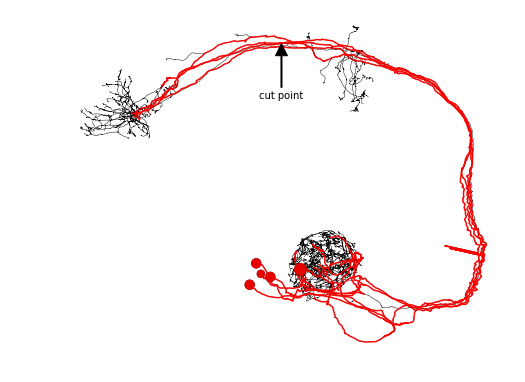

In [14]:
# Something more sophisticated: pruning by strahler index
n = nl[:5].prune_by_strahler( to_prune = [1,2,3], inplace=False )

# Plot original neurons in black
fig, ax = nl[:5].plot2d(color='black', method='2d', connectors=False)

# Plot pruned neurons in red
fig, ax = n.plot2d(color='red', method='2d', connectors=False, ax=ax, linewidth=1.5)

# Annotate cut point
ax.annotate('cut point', xy=(cut_coords[0], -cut_coords[1]), 
            xytext=(cut_coords[0], -cut_coords[1]-20000), va='center', ha='center',
            arrowprops=dict(facecolor='black', shrink=0.01, width=1),
            )

plt.show()

In [15]:
# Again, let's undo
nl.reload()

In [16]:
# Get a volume
lh = pymaid.get_volume('LH_R')

# Prune by volume
nl_lh = navis.in_volume(nl, lh, inplace=False)

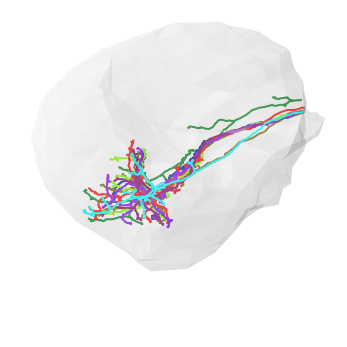

In [17]:
# Set color of volume
lh['color'] = (250,250,250,.2)

# Plot neurons that have some cable left and the volume
fig, ax = navis.plot2d([nl_lh[nl_lh.cable_length > 10], lh], 
                       method='3d', 
                       connectors=False, 
                       linewidth=2)

ax.dist=6
plt.show()